**Cargo Librerias**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk #Natural Language Tool Kit
import string #funciones adicionales para cadenas

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

import unidecode 
import unicodedata

#stemmer de libreria snowball
from nltk import SnowballStemmer 

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize  #convierte string en una lista
from nltk.tokenize.treebank import TreebankWordDetokenizer #  convierte una lista en un string.

import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error

import pacmap

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (matthews_corrcoef, roc_auc_score, recall_score, accuracy_score, average_precision_score,
                             f1_score, ConfusionMatrixDisplay, classification_report, precision_score)

from bertopic import BERTopic

# **<font color="red"> Carguio, preprocesamiento y limpieza</font>**

In [2]:
import pdfplumber 
reader=pdfplumber.open("Aylwin discurso democracia.pdf")

In [3]:
len(reader.pages)

81

**Concateneno la info de las paginas en una sola string gigante**

In [4]:
text=''
for page in range(0,len(reader.pages)):
    
    text+=reader.pages[page].extract_text()

**Elijo apriori separar los documentos entre puntos.**

In [5]:

regex=r'(?<=\.).*?(?=\.)'  #separo los distintos documentos usando puntos como mi unidad de separacion

frases = re.findall(regex, text, re.DOTALL)

#imprimimos el numero de frases de la busqueda
print(len(frases), '\n')

820 



**Aylwin comienza a hablar apartir de la frase con indice 4.** 

In [6]:
frases[:4]

[' MENSAJE PRESIDENCIAL\nEl señor VALDÉS (Presidente)',
 '- Su Excelencia el\nPresidente de la República concurre a esta sesión del\nCongreso Pleno para dar cuenta al país del estado\nadministrativo y político de la nación, de acuerdo con lo\nestablecido en el inciso final del artículo 24 de la\nConstitución Política del Estado',
 '\nCon tal propósito, tiene la palabra Su Excelencia el\nPresidente de la República',
 '\nEl señor AYLWIN (Presidente de la República)']

**Aylwin termina su discurso 5 indices antes del final de la lista de frases**

In [7]:
frases[-5:]

['\nEl señor VALDÉS (Presidente)',
 '- En conformidad a lo\ndispuesto en el artículo 51 de la Constitución Política de la\nRepública, declaro inaugurada la legislatura ordinaria del\nCongreso Nacional',
 '\nSe levanta la sesión',
 '\n-Se levantó a las 18:42',
 '\nManuel Ocaña Vergara,\nJefe de la Redacción']

**Planeo capturar solo el discurso de Aylwin por lo que eliminare de la lista de frases, las que no pertenezcan a este, del principio y final del texto.**

In [8]:
frases = frases[4:]
frases = frases[:-5]

In [9]:
for n in frases[:2]:
    print(f"{n}\n")

-
Conciudadanos del Senado y de la Cámara de Diputados:
Cumplo el deber que la Constitución impone al Presidente
de la República de dar cuenta al país, al menos una vez al
año, “del estado administrativo y político de la nación”


Aunque el texto constitucional vigente no prescribe ante
quién ha de rendirse esta cuenta ni la oportunidad de
hacerlo, pienso que lo más adecuado es restablecer la vieja
tradición histórica, que expresamente consagraba la
Constitución anterior, de rendir esta cuenta ante el Congreso
Pleno -el organismo más representativo de la nación toda-, en
la ocasión solemne en que inicia su legislatura ordinaria y
en esta fecha en que Chile conmemora uno de los ejemplos de
patriotismo de más alto significado moral de nuestra
historia



In [10]:
df = pd.DataFrame(frases, columns=['frases_crudas'])

In [11]:
print(df.iloc[2,:].values[0])  # Este es un ejemplo del problema que quiero solucionar acontinuacion.


CHILE DE NUEVO EN DEMOCRACIA2
Desde hace setenta días, los chilenos vivimos nuevamente
bajo un régimen democrático


**Con esta funcion pretendo eliminar las palabras con mas de una mayuscula seguida, lo cual al paracer solo sucede en casos como el de la foto a continuacion, donde se marca el inicio de un topico en concreto del discurso, considero que esto ensucia un poco mis frases, como se observa arriba.**

**Realizo esto ahora y no en la funcion de limpieza para mayor claridad, y porque la funcion de limpieza pasa a lowercase los caracteres al principio, por lo que esta funcion que aplicare acontinuacion no seria posible despues**

**tambien esta funcion se encargara de eliminar palabras como CORFO o SERNATEC** que posiblemente no aportan nada.

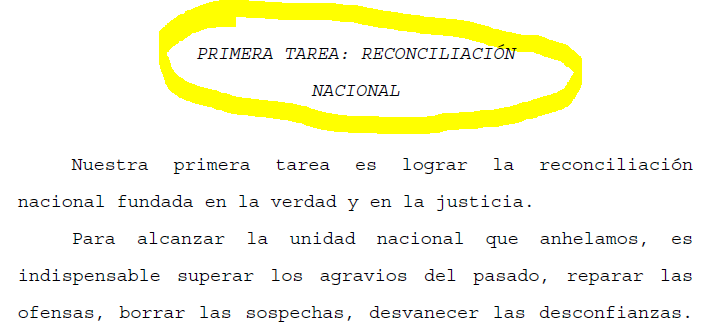

In [12]:
def remover_mayusculas_seguidas(texto):
    
    replacements = (             #Elimino las tildes de las mayuscalas ya que entorpecen mi funcion de regex
    ("Á", "A"),
    ("É", "E"),
    ("Í", "I"),
    ("Ó", "O"),
    ("Ú", "U"),  )
    
    for a, b in replacements:
        texto = texto.replace(a, b)
    
    texto_norm = re.sub(r'\b[A-Z][A-Z\d*\s]+\b','', texto)
    
    return texto_norm

In [13]:
df["frases_crudas"] = df.frases_crudas.apply(lambda x: remover_mayusculas_seguidas(x))

In [14]:
print(df.iloc[2,:].values[0])  #Problema se observa solucionado.


Desde hace setenta días, los chilenos vivimos nuevamente
bajo un régimen democrático


In [15]:
# for n in df[:].itertuples():
    
#     _ , content = n
    
#     print(f"Frase {_} :{content}\n")

**Voy a remover lo que esta entre parentesis, ya que tras una inspeccion visual rapida, lo que esta entre estos parecen ser reacciones "fisicas" del congreso ante el discurso de Aylwin, Considero que ensuciarian el analisis, las funcines dentro de la funcion limpieza mas abajo probablemente removerian los parentesis, pero la palabra "aplausos" seguiria estando.**

-ChatGPT me ayudo con las regex ya que son algo nuevas para mi, le pedi lo siguiente en este caso:

using re.sub function, give me a regex that finds what is between a parenthesis and replaces it with ""

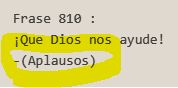

In [16]:
def remover_cosas_entre_parentesis(texto):

    # Find all matches in the text and replace them with an empty string
    modified_text = re.sub(r'\([^)]*\)', '', texto)
    
    return modified_text

In [17]:
df["frases_crudas"] = df.frases_crudas.apply(lambda x: remover_cosas_entre_parentesis(x))

In [18]:
print(df.iloc[810,:].values[0])  # Problema de parentesis solucionado.


¡Que Dios nos ayude!
-


**Tras una inspeccion visual, considero que mis frases estan listas para entrar a la funcion de limpieza general.**

In [19]:
# for n in df[:].itertuples():
    
#     _ , content = n
    
#     print(f"Frase {_} :{content}\n")

**Obtengo Stopwords en español y las limpio.**

In [20]:
#descargamos stopwords
nltk.download('stopwords')

#creamos lista de stopwords en castellano
stopwords=stopwords.words('spanish')

#normalizamos stopwords, removemos tildes y otros caracteres latinos para el match con texto normalizado
#creamos lista vacía que almacenara palabras normalizadas
stop_words=[]
#ciclo en el que cada palabra
for word in stopwords:
    #es normalizada
    word_norm = unicodedata.normalize('NFD', word).encode('ascii', 'ignore').decode("utf-8")
    
    #y almacenada en la nueva lista
    stop_words.append(word_norm)
    #print(word, word_norm)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\56976\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Creo funcion de limpieza, voy a lematizar ya que esto reduce mi dimensionalidad y me es potencialmente util para tareas de clustering posteriores, tambien creare una version tokenizada y limpia pero no lematizada de mi data.**

- Utilizare el Snowball Steammer, ya que el Steammer de Porter al parecer esta hecho solo para Ingles. (Posiblemente el stemming entorpezca mis analisis usando el lexico suminstrado por el profesor, vere como lo soluciono mas adelante.)

- Lidiare con los N-grams mas tarde. (tambien posiblemente entorpecerian analisis usando el lexico afin).

In [21]:
snowball = SnowballStemmer(language='spanish')

#creamos funcion que limpia y normaliza texto de la descripcion web
def limpieza(texto_norm, use_stopwords=True, stemming=True, erase_small_tokens=True, lower=True, detoken=False):
    
    if lower:
        #pasamos a minusculas
        texto_norm=texto_norm.lower()
    
    #removemos espacios al final y al inicio de cada cadena
    texto_norm=texto_norm.strip()
    
    #removemos dobles espacios
    texto_norm=re.sub('\s',' ', texto_norm)
    
    #nuevo_texto = unidecode.unidecode(nuevo_texto)
    texto_norm = unicodedata.normalize('NFD', texto_norm).encode('ascii', 'ignore').decode("utf-8")
    
    #retenemos caracteres del tipo letra
    texto_norm=re.sub('[^A-Za-z]+', ' ', texto_norm)
    
    #removemos dobles espacios
    texto_norm=re.sub('\s',' ', texto_norm)
    
    #tokenizamos texto: convertir en una lista una cadena
    texto_norm = word_tokenize(texto_norm)
    
    if erase_small_tokens:
        # Eliminación de terminos de largo 2
        texto_norm = [token for token in texto_norm if len(token) > 2]
        
    if use_stopwords:
        #removemos stopwords
        texto_norm=[word for word in texto_norm if not word in stop_words]
        
    if stemming:
        #lematizamos
        texto_norm=[snowball.stem(word) for word in texto_norm]
    
    if detoken:
        detok=TreebankWordDetokenizer()
        texto_norm = detok.detokenize(texto_norm)
    
    return(texto_norm)

In [22]:
#implementamos la funcion de limpieza y normalizacion
df['frases_preprocesadas_tokenizadas'] = df['frases_crudas'].apply(lambda x: limpieza(x))

df["frases_crudas"] = df["frases_crudas"].apply(lambda x: limpieza(x,lower=False, erase_small_tokens=False,
                                                                  stemming=False, use_stopwords=False, detoken=True))

df['frases_preprocesadas_tokenizadas_sin_lematizar'] = df['frases_crudas'].apply(lambda x: limpieza(x, stemming=False))

df = df.rename(columns={"frases_crudas":"frases_limpias"})
 
df["largo_de_documento"] = df['frases_preprocesadas_tokenizadas'].apply(lambda x: len(x))

#Elimino parrafos que tengan un largo inferior a 4
df = df.loc[df["largo_de_documento"] > 3, :].reset_index(drop=True)


In [23]:
df.sort_values(by="largo_de_documento")

,frases_limpias,frases_preprocesadas_tokenizadas,frases_preprocesadas_tokenizadas_sin_lematizar,largo_de_documento
124,Una administracion de justicia eficiente y opo...,"[administr, justici, eficient, oportun]","[administracion, justicia, eficiente, oportuna]",4
181,Es el riesgo inherente a la funcion publica,"[riesg, inherent, funcion, public]","[riesgo, inherente, funcion, publica]",4
126,Mecanismos eficientes y justos de seguridad de...,"[mecan, eficient, just, segur]","[mecanismos, eficientes, justos, seguridad]",4
690,Haremos de este planteamiento una tarea nacional,"[har, planteamient, tare, nacional]","[haremos, planteamiento, tarea, nacional]",4
701,La gente esta contenta de vivir en libertad,"[gent, content, viv, libert]","[gente, contenta, vivir, libertad]",4
...,...,...,...,...
538,Nuestros objetivos ante la Comunidad Economica...,"[objet, comun, econom, europe, clar, concret, ...","[objetivos, comunidad, economica, europea, cla...",50
24,En analogo sentido es tambien un hecho auspici...,"[analog, hech, auspici, curs, campan, electora...","[analogo, hecho, auspicioso, curso, campana, e...",54
558,Los objetivos de nuestra politica minera son v...,"[objet, polit, miner, vari, asum, rol, mayor, ...","[objetivos, politica, minera, varios, asumir, ...",60
683,Los objetivos ante la Comunidad Economica Euro...,"[objet, comun, econom, europe, clar, concret, ...","[objetivos, comunidad, economica, europea, cla...",60


**Quedaron guapas las frases limpias.**, son perfectamente entendibles, aunque le falten algunos acentos y comas. Las guardare para mas adelante.

- **debo recordar que a estas <font color="red">frases limpias</font> recien creadas les faltan algunas etapas de preprocesamiento** ej: lowercase

- **las <font color="red">frases_preprocesadas_tokenizadas</font> tienen todas las etapas de preprocesamiento, incluye lematizacion lematizacion.**

- **las  <font color="red">frases_preprocesadas_tokenizadas_sin_lematizar</font> tiene todas las etapas de preprocesamiento, sin lematizar**

In [24]:
for n in df[:5].itertuples():
    
    i , frases_limpia, _, _,_ = n
    
    print(f"Frase {i}: {frases_limpia}\n")

Frase 0: Conciudadanos del Senado y de la Camara de Diputados Cumplo el deber que la Constitucion impone al Presidente de la Republica de dar cuenta al pais al menos una vez al ano del estado administrativo y politico de la nacion

Frase 1: Aunque el texto constitucional vigente no prescribe ante quien ha de rendirse esta cuenta ni la oportunidad de hacerlo pienso que lo mas adecuado es restablecer la vieja tradicion historica que expresamente consagraba la Constitucion anterior de rendir esta cuenta ante el Congreso Pleno el organismo mas representativo de la nacion toda en la ocasion solemne en que inicia su legislatura ordinaria y en esta fecha en que Chile conmemora uno de los ejemplos de patriotismo de mas alto significado moral de nuestra historia

Frase 2: Desde hace setenta dias los chilenos vivimos nuevamente bajo un regimen democratico

Frase 3: El gobierno de la nacion por autoridades libremente elegidas por el pueblo para un plazo preestablecido bajo un sistema que asegura 

**Creo vocabulario sin la data lematizada**

In [25]:
#creamos data frame que intersecta a cada articulo con cada termino

doc_term_sin_lemat = df.explode(column='frases_preprocesadas_tokenizadas_sin_lematizar')

#cambiamos nombre de columna para identificar termino
doc_term_sin_lemat = doc_term_sin_lemat.rename(columns={'frases_preprocesadas_tokenizadas_sin_lematizar':'termino'})

vocabulario_sin_lemat = doc_term_sin_lemat.groupby(['termino']).count().sort_values(by='largo_de_documento', ascending=False).reset_index()

#cambiamos nombre para identificar frecuencia del termino
vocabulario_sin_lemat  = vocabulario_sin_lemat.rename(columns={'largo_de_documento':'frecuencia'})

#vocabulario = vocabulario[vocabulario.frecuencia > 2]  

#agregamos columna con el ranking
vocabulario_sin_lemat['ranking']=vocabulario_sin_lemat.index+1

vocabulario_sin_lemat = vocabulario_sin_lemat.drop(["frases_limpias","frases_preprocesadas_tokenizadas"],axis=1)

print(vocabulario_sin_lemat.shape)

vocabulario_sin_lemat.head()


(3957, 3)


,termino,frecuencia,ranking
0,gobierno,95,1
1,nacional,82,2
2,pais,80,3
3,chile,66,4
4,desarrollo,64,5


**Creo vocabulario con la data lematizada**

In [26]:
#creamos data frame que intersecta a cada articulo con cada termino

doc_term_lematizado = df.explode(column='frases_preprocesadas_tokenizadas')

#cambiamos nombre de columna para identificar termino
doc_term_lematizado = doc_term_lematizado.rename(columns={'frases_preprocesadas_tokenizadas':'termino'})

vocabulario = doc_term_lematizado.groupby(['termino']).count().sort_values(by='largo_de_documento', ascending=False).reset_index()

#cambiamos nombre para identificar frecuencia del termino
vocabulario  = vocabulario.rename(columns={'largo_de_documento':'frecuencia'})

#vocabulario = vocabulario[vocabulario.frecuencia > 2]  

#agregamos columna con el ranking
vocabulario['ranking']=vocabulario.index+1

vocabulario = vocabulario.drop(["frases_limpias","frases_preprocesadas_tokenizadas_sin_lematizar"],axis=1)

print(vocabulario.shape)

vocabulario.head()

(2323, 3)


,termino,frecuencia,ranking
0,gobiern,97,1
1,nacional,89,2
2,pais,89,3
3,sector,87,4
4,polit,86,5


**Observamos de lo anterior que el vocabulario sin lematizar tiene una dimensionalidad mucho mayor**. (2323 vs 3957)

**Ahora realizare unos graficos "lollypop" de los terminos mas frecuentes en ambos vocabularios (sin lematizar y lematizado).**


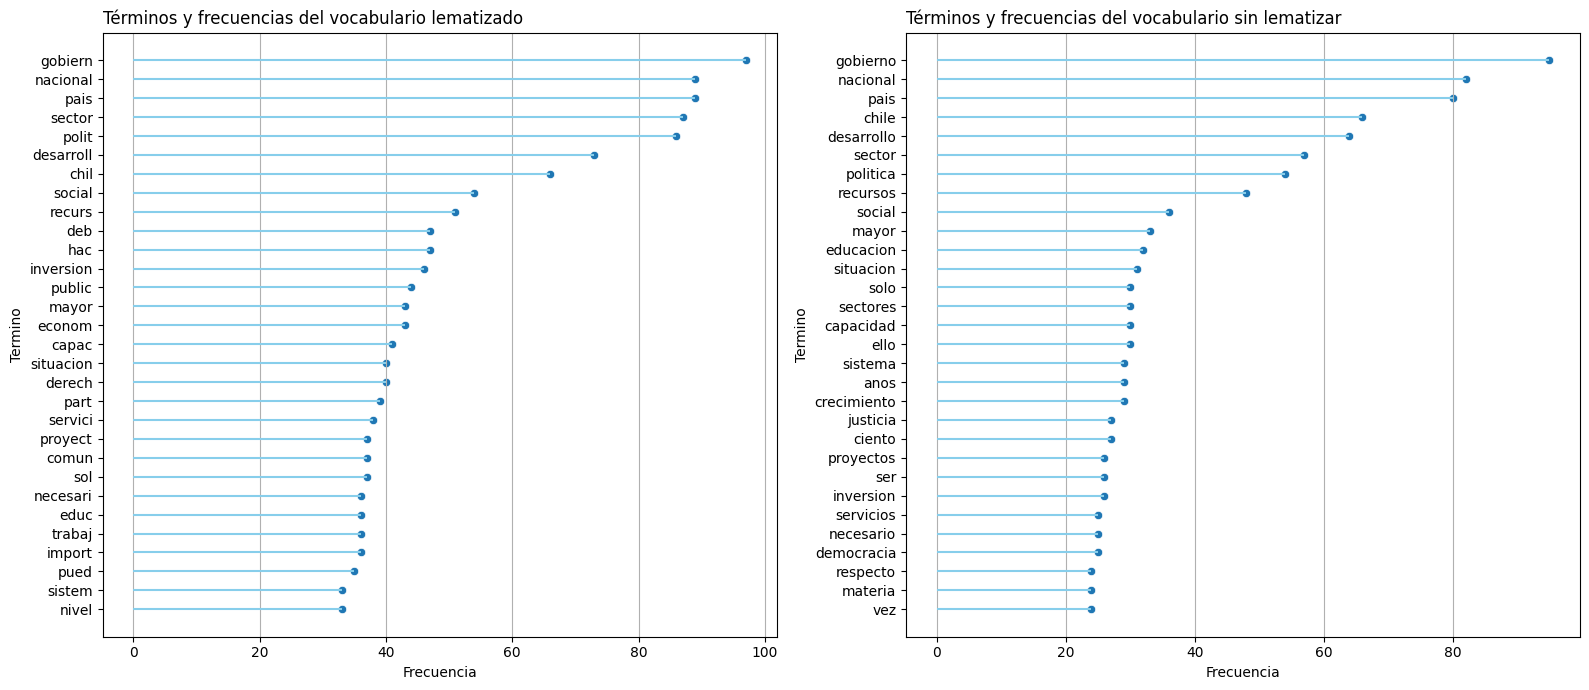

In [27]:
#creamos rango
top_palabras = 30

plt.figure(figsize=(16,7),dpi=100)

plt.subplot(1,2,1)
sns.scatterplot(x = vocabulario['frecuencia'].head(top_palabras), y= vocabulario['termino'].head(top_palabras));
plt.hlines(y=vocabulario['termino'].head(top_palabras), xmin=0, xmax=vocabulario['frecuencia'].head(top_palabras), color='skyblue');
plt.title("Términos y frecuencias del vocabulario lematizado", loc='left')
plt.xlabel('Frecuencia')
plt.ylabel('Termino');
plt.grid(visible=True,axis="x")

plt.subplot(1,2,2)
sns.scatterplot(x = vocabulario_sin_lemat['frecuencia'].head(top_palabras), y= vocabulario_sin_lemat['termino'].head(top_palabras));
plt.hlines(y=vocabulario_sin_lemat['termino'].head(top_palabras), xmin=0, xmax=vocabulario_sin_lemat['frecuencia'].head(top_palabras), color='skyblue');
plt.title("Términos y frecuencias del vocabulario sin lematizar", loc='left')
plt.xlabel('Frecuencia')
plt.ylabel('Termino');
plt.grid(visible=True,axis="x")


plt.tight_layout()


# <font color="red">**LEY DE ZIPF**</font>

**tengo la intuicion de que el texto/vocabulario del discurso de Aylwin es muy pequeño para que el comportamiento que esta ley señala emerga de forma perfecta, pero deberiamos ser capaz de notar la estructura que esta señala en general.**

Zipf's law is a statistical observation that states that in a large sample of text, the frequency of a word is inversely proportional to its rank in the frequency table. This means that the most common word will occur much more frequently than the second most common word, and so on. The law is named after George Zipf, who first proposed it in the 1930s.

In general, the larger the sample of text, the more evident Zipf's law will be. However, it is possible to observe the effects of Zipf's law even in smaller samples of text. The size of the sample will affect the accuracy of the frequency distribution, but the general patterns described by Zipf's law should still be evident even in smaller samples.

It is worth noting that Zipf's law is not a strict rule and there will always be exceptions. However, it is a useful tool for analyzing language usage and can provide insights into the structure of a language.



**Voy a implementar la ley de Zipf con la version mejorada de Mandelbrot, que es mas flexible y permite un mayor ajuste.**

- [link_de_referencia](https://ids-pub.bsz-bw.de/frontdoor/deliver/index/docId/4223/file/Koplenig_Using_the_parameters_of_the_Zipf_Mandelbrot_2015.pdf)
- [link_de_referencia](https://www.youtube.com/watch?v=vE8Rcrq3f6U)
- [link de referencia](http://web.utk.edu/~scolli46/zipfmandelbrotmc.html)

$$ P_{r} = \frac{c}{(rank + b)^a}$$


**Primero utilizare el vocabulario lematizado.**

- aqui utilizo busqueda bayesiana para encontrar los mejores parametros que minimizen una metrica de error en concreto.

In [28]:
def objective(trial):
    
    a = trial.suggest_float("a", 0.01, 2)  #buscamos valores entre 0.1 y 2 para alpha.
    b = trial.suggest_float("b", 0.01, 4)
    c = trial.suggest_int("c",10,500, step=2)
    
    frequencia_real = vocabulario.frecuencia.values
    frequencia_estimada_zipf = c/((vocabulario.ranking + b)**a).values
    #frequencia_estimada_zipf = vocabulario.frecuencia[0]/(vocabulario.ranking**a).values
    #rmse = mean_squared_error(frequencia_real, frequencia_estimada_zipf)**0.5
    rmsle = mean_squared_log_error(frequencia_real, frequencia_estimada_zipf,squared=False)

    #return rmsle
    return rmsle

In [29]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction="minimize", study_name="fit_lem_vocab",sampler=TPESampler())
func = lambda trial: objective(trial)
study.optimize(func, n_trials=1000)

In [30]:
study.best_params, study.best_value

({'a': 0.7770055894531288, 'b': 3.207521679309849, 'c': 500},
 0.2252968505972626)

In [31]:
a = study.best_params["a"]
b = study.best_params["b"]
c = study.best_params["c"]

vocabulario['frecuencia_estimada'] = c/((vocabulario.ranking + b)**a).values

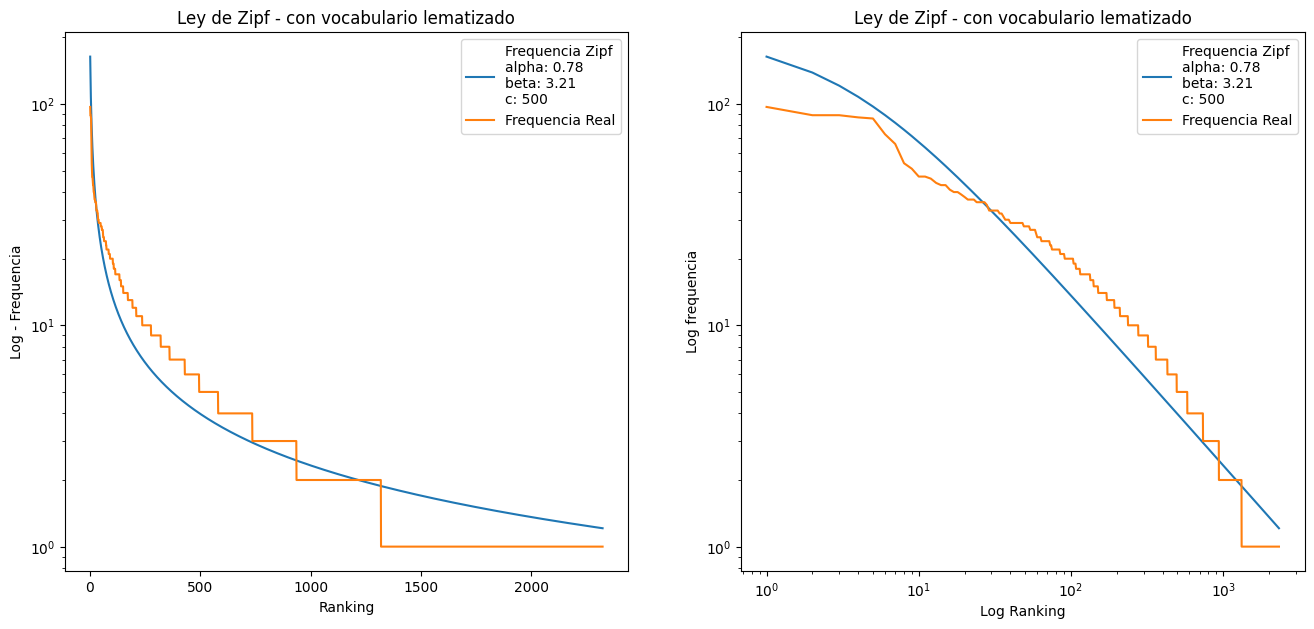

In [32]:
#Graficamos la Ley de Zipf
plt.figure(figsize=(16,7),dpi=100)

ax1 = plt.subplot(1,2,1)
plt.plot(vocabulario.ranking, vocabulario.frecuencia_estimada, label=f"Frequencia Zipf\nalpha: {np.round(a,2)}\nbeta: {np.round(b,2)}\nc: {c}")
plt.plot(vocabulario.ranking, vocabulario.frecuencia, label="Frequencia Real")

ax1.set_yscale('log')
plt.title('Ley de Zipf - con vocabulario lematizado')
plt.xlabel("Ranking")
plt.ylabel("Log - Frequencia")
plt.legend();

ax2 = plt.subplot(1,2,2)
        
plt.plot(vocabulario.ranking, vocabulario.frecuencia_estimada , label=f"Frequencia Zipf\nalpha: {np.round(a,2)}\nbeta: {np.round(b,2)}\nc: {c}")
plt.plot(vocabulario.ranking, vocabulario.frecuencia, label="Frequencia Real")

# Agregamos titulo y nombres en los ejes
ax2.set_yscale('log')
ax2.set_xscale("log")
plt.title('Ley de Zipf - con vocabulario lematizado')
plt.xlabel("Log Ranking")
plt.ylabel("Log frequencia")
plt.legend();

**Ahora calculare la ley de zipf con el texto sin lematizar**

In [33]:
def objective(trial):
    
    a = trial.suggest_float("a", 0.01, 2)  #buscamos valores entre 0.1 y 2 para alpha.
    b = trial.suggest_float("b", 0.01, 4)
    c = trial.suggest_int("c",10,500, step=2)
    
    frequencia_real = vocabulario_sin_lemat.frecuencia.values
    frequencia_estimada_zipf = c/((vocabulario_sin_lemat.ranking + b)**a).values
    #frequencia_estimada_zipf = vocabulario.frecuencia[0]/(vocabulario.ranking**a).values
    #rmse = mean_squared_error(frequencia_real, frequencia_estimada_zipf)**0.5
    rmsle = mean_squared_log_error(frequencia_real, frequencia_estimada_zipf,squared=False)

    #return rmsle
    return rmsle

In [34]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction="minimize", study_name="fit_lem_vocab",sampler=TPESampler())
func = lambda trial: objective(trial)
study.optimize(func, n_trials=1000)

In [35]:
study.best_params , study.best_value

({'a': 0.7735314140430375, 'b': 3.874964025510163, 'c': 482},
 0.11555551774202145)

In [36]:
a = study.best_params["a"]
b = study.best_params["b"]
c = study.best_params["c"]

vocabulario_sin_lemat['frecuencia_estimada'] = c/((vocabulario_sin_lemat.ranking + b)**a).values

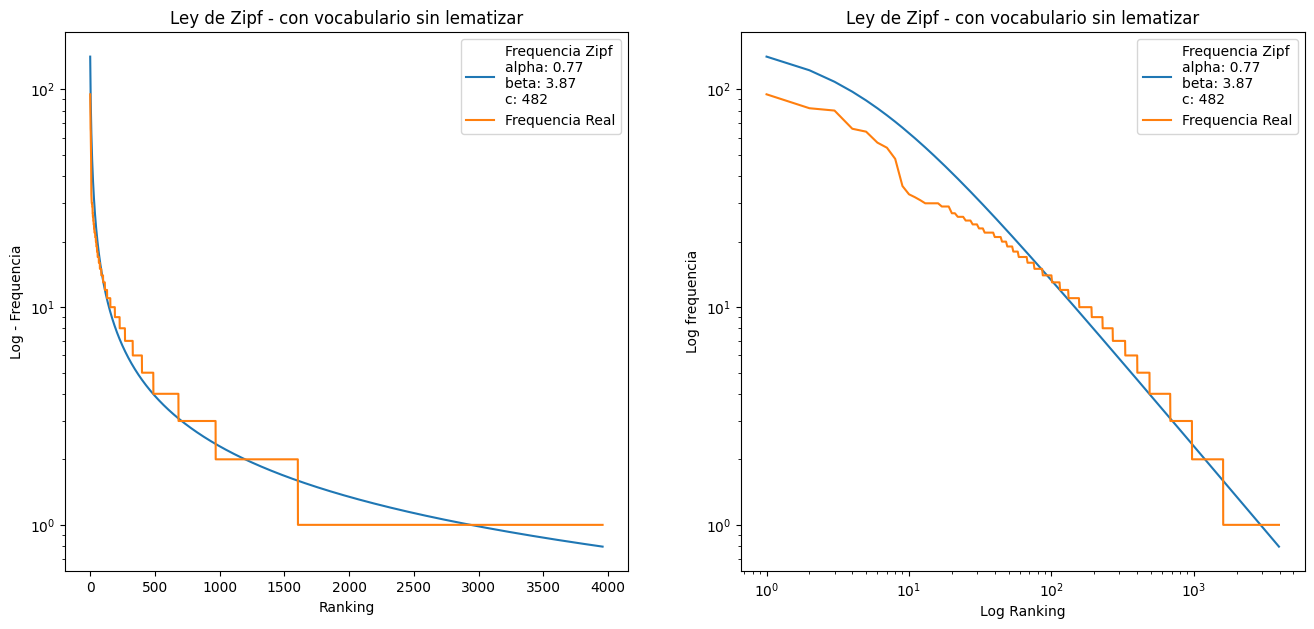

In [37]:
#Graficamos la Ley de Zipf
plt.figure(figsize=(16,7),dpi=100)

ax1 = plt.subplot(1,2,1)
plt.plot(vocabulario_sin_lemat.ranking, vocabulario_sin_lemat.frecuencia_estimada, label=f"Frequencia Zipf\nalpha: {np.round(a,2)}\nbeta: {np.round(b,2)}\nc: {c}")
plt.plot(vocabulario_sin_lemat.ranking, vocabulario_sin_lemat.frecuencia, label="Frequencia Real")

ax1.set_yscale('log')
plt.title('Ley de Zipf - con vocabulario sin lematizar')
plt.xlabel("Ranking")
plt.ylabel("Log - Frequencia")
plt.legend();

ax2 = plt.subplot(1,2,2)
        
plt.plot(vocabulario_sin_lemat.ranking, vocabulario_sin_lemat.frecuencia_estimada , label=f"Frequencia Zipf\nalpha: {np.round(a,2)}\nbeta: {np.round(b,2)}\nc: {c}")
plt.plot(vocabulario_sin_lemat.ranking, vocabulario_sin_lemat.frecuencia, label="Frequencia Real")

# Agregamos titulo y nombres en los ejes
ax2.set_yscale('log')
ax2.set_xscale("log")
plt.title('Ley de Zipf - con vocabulario sin lematizar')
plt.xlabel("Log Ranking")
plt.ylabel("Log frequencia")
plt.legend();

**Pareciera que la ley de zipf ajusta mejor a el texto sin lematizar**

**En todo caso apreciando las curvas considero que en general se cumple la ley de zipf tanto para el texto lematizado como no lematizado**

# <font color="red">**LEY DE HEAPS**</font>

Heaps' law is a statistical observation that describes the relationship between the size of a document (in terms of the number of words it contains) and the vocabulary size of the document (the number of unique words it contains). Heaps' law states that the vocabulary size increases at a slower rate than the size of the document, and can be described by the equation V = K * N^b, where V is the vocabulary size, N is the size of the document, K and b are constants that depend on the language and the specific text being analyzed.

Like Zipf's law, Heaps' law is not a strict rule and there will always be exceptions. However, it is a useful tool for analyzing language usage and can provide insights into the structure of a language. In general, the larger the size of the document, the more evident Heaps' law will be. However, it is possible to observe the effects of Heaps' law even in smaller documents. The size of the document will affect the accuracy of the vocabulary size estimates, but the general patterns described by Heaps' law should still be evident even in smaller documents.

In [38]:
terminos_unicos = pd.DataFrame(df["frases_preprocesadas_tokenizadas_sin_lematizar"].apply(lambda x: len(np.unique(x))))

terminos_unicos = terminos_unicos.rename(columns={"frases_preprocesadas_tokenizadas_sin_lematizar": "terminos_distintos"})


terminos_totales = pd.DataFrame(df["frases_preprocesadas_tokenizadas_sin_lematizar"].apply(lambda x: len(x)))

terminos_totales = terminos_totales.rename(columns={"frases_preprocesadas_tokenizadas_sin_lematizar": "terminos_totales"})

heaps = pd.concat([terminos_totales , terminos_unicos], axis=1).sort_values(by='terminos_distintos', ascending=True)

Por lo que he visto en internet la ley de heaps muchas veces es aplicada a tamaños de documentos gigantes, como libros enteros.

Es muy probable que nos encontremos con algo lineal y no concavo muy concavo, ya que los documentos de este proyecto no son lo suficientemente grandes para que se aprecie la ley de heaps.

602 documentos de 714, tienen igual cantidad de terminos totales y unicos.

Una posible solucion seria considerar una unidad de documento mas grande, como una pagina (ahi habria mas cantidad de terminos totales != terminos unicos por documento). Sin embargo, La ley de heaps no es una regla estricta, pretendo seguir utilizando el nivel de granularidad de documento seleccionado inicalmente.

In [39]:
sum(terminos_totales.values == terminos_unicos.values) , heaps.shape[0]

(array([602]), 714)

$$ V = KN^β $$

- K is a constant
- β is the scaling exponent 
- N is the size of the document.

The values of K and β depend on the language, genre, and topic of the document, and can vary widely.<br>

For example, in English text, the value of β is typically between 0.4 and 0.6, while the value of K can vary from around 10 to 100. In technical or specialized documents, the values of β and K may be higher, as the text is likely to contain more rare and specialized terms.

In [40]:
def objective(trial):
    
    K = trial.suggest_int("K", 1, 150) 
    beta = trial.suggest_float("beta", 0.1, 0.9)
     
    terminos_distintos = heaps.terminos_distintos
    estimacion_terminos_distintos = K * heaps.terminos_totales**beta

    rmse = mean_squared_error(terminos_distintos, estimacion_terminos_distintos, squared=False)
    rmsle = mean_squared_log_error(terminos_distintos, estimacion_terminos_distintos, squared=False)

    #return rmsle
    return rmse

In [41]:
study = optuna.create_study(direction="minimize", study_name="heaps_best_params",sampler=TPESampler())
func = lambda trial: objective(trial)
study.optimize(func, n_trials=1500)

In [42]:
study.best_params, study.best_value

({'K': 3, 'beta': 0.6323207890434097}, 3.067131503680695)

In [43]:
K= study.best_params["K"]
beta= study.best_params["beta"]

heaps['V']=(K*heaps.terminos_totales**beta)

- **Utilizando mi nivel de documento inicial (separando distintos documento segun puntos "."), se alcanza a apareciar una concavidad muy leve.**<br>
- **Observamos que todos los puntos se encuentran por debajo de la recta lineal con pendiente 1.**<br>
- **Se logra inferir de los graficos que el comportamiento principal de la ley de heaps se cumple, la cantidad de palabras unicas del documento, aumenta a un ritmo cada vez mas bajo, a mayor tamaño de palabras totales dentro del documento**<br>

**Sin embargo observamos que nuestra data no tiene el mejor ajuste a la formula de la ley de heaps, incluso cuando buscamos parametros optimos**

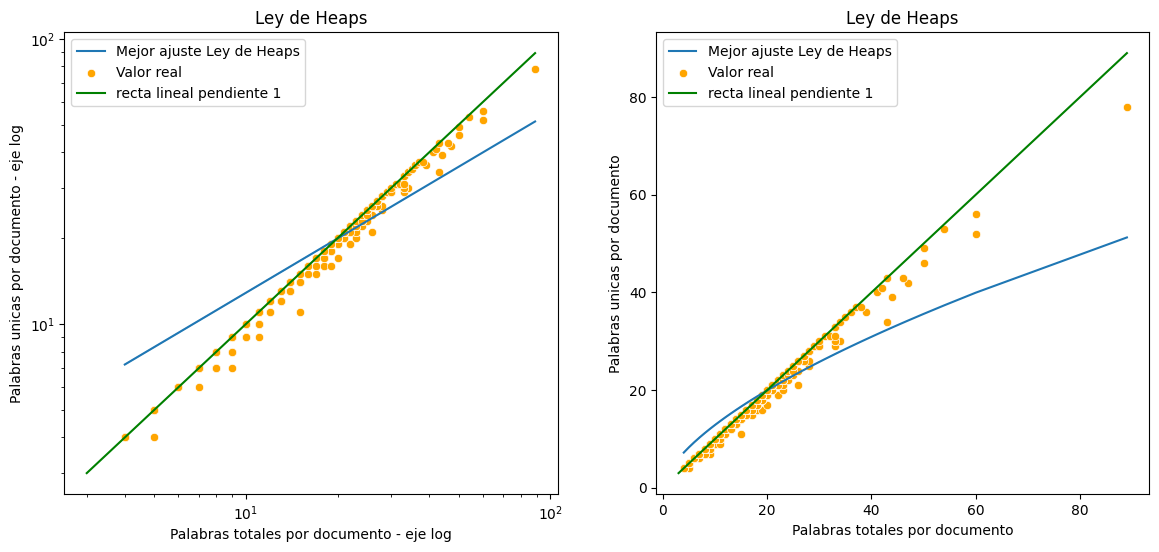

In [44]:
#Graficamos la Ley de Heaps
plt.figure(figsize=(14,6),dpi=100)

plt.subplot(1,2,1)


#lineplot #scatterplot

sns.lineplot(x=heaps.terminos_totales, y=heaps.V, label="Mejor ajuste Ley de Heaps");
sns.scatterplot(x=heaps.terminos_totales, y=heaps.terminos_distintos, label="Valor real", color="orange");
sns.lineplot(x=np.arange(3,90) ,y=np.arange(3,90), label="recta lineal pendiente 1", color="green");
# Agregamos titulo y nombres en los ejes
plt.title('Ley de Heaps')
plt.xlabel("Palabras totales por documento - eje log")
plt.ylabel("Palabras unicas por documento - eje log")
plt.yscale('log')
plt.xscale("log")


plt.subplot(1,2,2)
sns.lineplot(x=heaps.terminos_totales, y=heaps.V, label="Mejor ajuste Ley de Heaps");
sns.scatterplot(x=heaps.terminos_totales, y=heaps.terminos_distintos, label="Valor real", color="orange");
sns.lineplot(x=np.arange(3,90) ,y=np.arange(3,90), label="recta lineal pendiente 1", color="green");
# Agregamos titulo y nombres en los ejes
plt.title('Ley de Heaps')
plt.xlabel("Palabras totales por documento")
plt.ylabel("Palabras unicas por documento");


**Voy a de forma express realizar la ley de heaps con las paginas como mi tamaño de documento**

In [45]:
z = pd.DataFrame(columns=["paginas"])

for page in range(0,len(reader.pages)):

    z.loc[z.shape[0]] = reader.pages[page].extract_text()
    
z.iloc[0].values[0] = z.iloc[0].values[0][535:] #elimino partes del texto al inicio donde no habla aylwin
z.iloc[z.shape[0]-1].values[0] = z.iloc[z.shape[0]-1].values[0][:898] #elimino partes del texto al final donde no habla aylwin

z["paginas_limpias"] = z["paginas"].apply(lambda x : remover_mayusculas_seguidas(x))
z["paginas_limpias"] = z["paginas_limpias"].apply(lambda x : remover_cosas_entre_parentesis(x))
z["paginas_limpias"] = z["paginas_limpias"].apply(lambda x : limpieza(x, stemming=False))


terminos_unicos = pd.DataFrame(z["paginas_limpias"].apply(lambda x: len(np.unique(x))))
terminos_unicos = terminos_unicos.rename(columns={"paginas_limpias": "terminos_distintos"})


terminos_totales = pd.DataFrame(z["paginas_limpias"].apply(lambda x: len(x)))
terminos_totales = terminos_totales.rename(columns={"paginas_limpias": "terminos_totales"})

heaps = pd.concat([terminos_totales , terminos_unicos], axis=1).sort_values(by='terminos_distintos', ascending=True)

#heaps = heaps[2:]

In [46]:
def objective(trial):
    
    K = trial.suggest_int("K", 3, 150) 
    beta = trial.suggest_float("beta", 0.2, 0.9)
    #intercept = trial.suggest_float("intercept", 0,80)    #voy a agregarle un interceptor a la ley de heaps para mayor bondad de ajuste.
     
    terminos_distintos = heaps.terminos_distintos
    estimacion_terminos_distintos = (K * heaps.terminos_totales**beta)  #+ intercept

    rmse = mean_squared_error(terminos_distintos, estimacion_terminos_distintos, squared=False)
    rmsle = mean_squared_log_error(terminos_distintos, estimacion_terminos_distintos, squared=False)

    #return rmsle
    return rmse


study = optuna.create_study(direction="minimize", study_name="heaps_best_params",sampler=TPESampler())
func = lambda trial: objective(trial)
study.optimize(func, n_trials=1500)

study.best_params, study.best_value


({'K': 5, 'beta': 0.6418901263629349}, 5.925450434797583)

In [47]:
K= study.best_params["K"]
beta= study.best_params["beta"]
#intercept = study.best_params["intercept"]

heaps['V']=(K*heaps.terminos_totales**beta) #+ intercept

**Utilizando a las paginas como tamaño de documento, apreciamos un mayor nivel de evidencia de la ley heaps que cuando nuestros documentos fueron seleccionados utilizando "." como unidad separadora**

**Nuestros valores reales se encuentran mucho mas apegados a la ley de heaps y mucho mas distanciados de la recta lineal de pendiente 1**.

En resumen lo que se aprende de aca es:

- Potencialmente a mayor tamaño de documento, mas se aprecia la ley de heaps.

**<font color="red"> La ley de heaps al igual que la ley de zipf no es una regla obligatoria, seguire trabajando con mi tamaño de documento seleccionado utilizando "." como unidad separadora</font>**

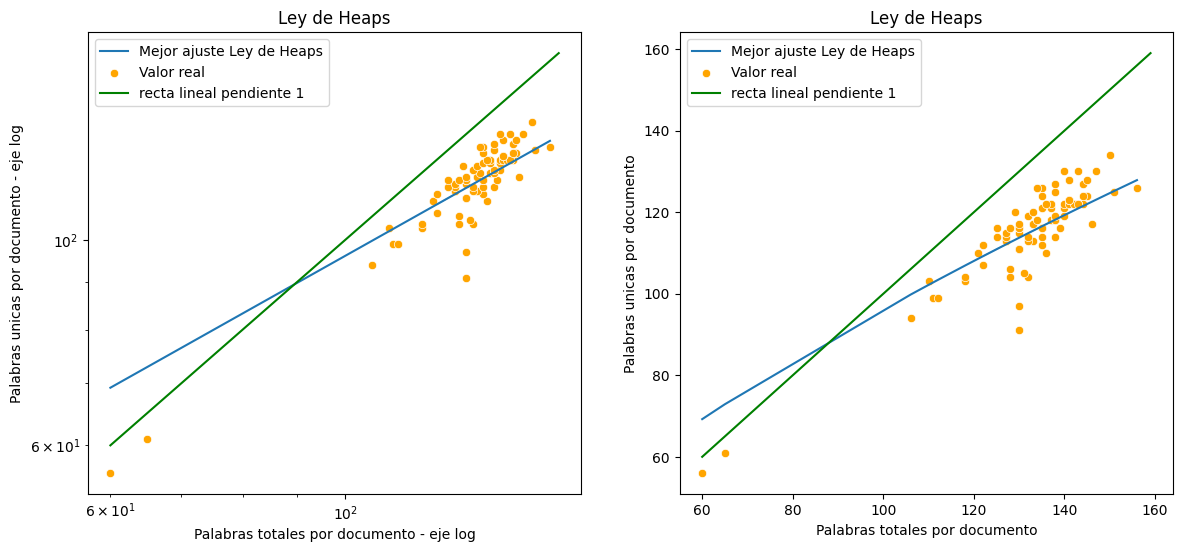

In [48]:
#Graficamos la Ley de Heaps
plt.figure(figsize=(14,6),dpi=100)

plt.subplot(1,2,1)


#lineplot #scatterplot

sns.lineplot(x=heaps.terminos_totales, y=heaps.V, label="Mejor ajuste Ley de Heaps");
sns.scatterplot(x=heaps.terminos_totales, y=heaps.terminos_distintos, label="Valor real", color="orange");
sns.lineplot(x=np.arange(60,160) ,y=np.arange(60,160), label="recta lineal pendiente 1", color="green");
# Agregamos titulo y nombres en los ejes
plt.title('Ley de Heaps')
plt.xlabel("Palabras totales por documento - eje log")
plt.ylabel("Palabras unicas por documento - eje log")
plt.yscale('log')
plt.xscale("log")


plt.subplot(1,2,2)
sns.lineplot(x=heaps.terminos_totales, y=heaps.V, label="Mejor ajuste Ley de Heaps");
sns.scatterplot(x=heaps.terminos_totales, y=heaps.terminos_distintos, label="Valor real", color="orange");
sns.lineplot(x=np.arange(60,160) ,y=np.arange(60,160), label="recta lineal pendiente 1", color="green")
# Agregamos titulo y nombres en los ejes
plt.title('Ley de Heaps')
plt.xlabel("Palabras totales por documento")
plt.ylabel("Palabras unicas por documento");


# <font color="red"> TF-IDF Vectorizer y clustering</font>

TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure used to evaluate the importance of a word in a document or a collection of documents. It is often used in information retrieval and text mining to determine the relevance of a document to a particular query or to a set of documents.

The term frequency TF(t, d) reflects how important a term is within a single document. The inverse document frequency IDF(t, D) reflects how rare a term is across the entire document collection


**N-grams**

It is generally a good idea to use N-grams when working with small corpora, as they can help to capture more of the structure and context of the language in your data. N-grams are sequences of N consecutive words, where N is a positive integer. For example, a bigram is a sequence of two words, a trigram is a sequence of three words, and so on.

Using N-grams can be especially useful when working with small corpora, because they can help to capture more of the structure and context of the language in your data. For example, if you are working with a small corpus of text and you are interested in understanding the relationships between different words, you could use N-grams to identify common patterns or themes in the text.

However, it is important to keep in mind that using N-grams can also increase the complexity of your model and may not always be the best approach. It is a good idea to experiment with different N-gram sizes and see which works best for your specific use case.

In [49]:
detok = TreebankWordDetokenizer()

entrada_sin_lematizar = df.frases_preprocesadas_tokenizadas_sin_lematizar.apply(lambda x : detok.detokenize(x))
    

**No me gusta utilizar la data lematizada para tareas clustering, personalmente hace muy dificil la interpretacion a mi gusto, aunque la lematizacion tiene el beneficio de dimensionalidad reducida.**

- <font color="red"> Experimento 1</font>: Como Primer aproach the clustering utilizare Uni-gramas en la data no lematizada, usare Max Tokens = 1000
- <font color="red"> Experimento 2</font>: Como segundo aproach utilizare la data no lematizada y bi-gramas para hacer clustering, usare Max Token = 3000.

No existe apriori a ciencia cierta que es lo que mas me conviene, la mejor opcion es, experimentar y experimentar, revisare los resultados de los clusters y vere cual es mas "util".

**Me sobre extenderia mucho probando mas combinaciones, creo que con los 2 experimentos señalados arriba deberia bastar**.

<font color="red" size="6"> Experimento 1</font>

In [50]:
tfidf_vect = TfidfVectorizer(tokenizer=None, 
                             lowercase=False,
                            use_idf=True,
                            ngram_range=(1,1),
                            max_features=1000)

#ajustamos vectorizador a los datos
tfidf_vect.fit(entrada_sin_lematizar)

#implementamos matriz tf-idf
tfidf_data_unigram_sin_lematizar= tfidf_vect.transform(entrada_sin_lematizar)

tfidf_df_unigram_sin_lematizar = pd.DataFrame(tfidf_data_unigram_sin_lematizar.toarray(), columns=tfidf_vect.get_feature_names_out())

**Aplico PCA con 200 componentes principales aca tambien retiene alrededor de un 60% de la varianza original.**

In [51]:
pca = PCA(n_components=200).fit(tfidf_data_unigram_sin_lematizar.toarray())
pca_data = pca.transform(tfidf_data_unigram_sin_lematizar.toarray())
np.sum(pca.explained_variance_ratio_)

0.6453613312278852

**RESULTADOS NO REPRODUCIBLES**

In [2]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1,1)

    sse = []
    for k in iters:

        sse.append(KMeans(n_clusters=k,
                           random_state=20).fit(data).inertia_)

    plt.figure(figsize=(12,6),dpi=100)

    plt.plot(iters, sse, marker='o')
    plt.xlabel('Numero de clusters')
    plt.xticks(iters)
    plt.grid(visible=True)
    plt.ylabel('SSE')
    plt.title('SSE según centro de Cluster')

#Obtenemos las 15 palabras mas frencuentes de cada cluster
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()

    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(', '.join([labels[t] for t in np.argsort(r)[-n_terms:]]))

find_optimal_clusters(pca_data, 20)

**El mejor corte se observa en 4 o 7 en mi opinion**, aunque el elbow sigue siendo feo.

In [53]:
import warnings

warnings.filterwarnings("ignore")

clusters = KMeans(n_clusters=4, random_state=20).fit_predict(pca_data)
pd.Series(clusters).value_counts()

2    547
3    113
1     33
0     21
dtype: int64

**Es bastante dificil interpretar los clusters, pero "creo" entender lo siguiente en base a las palabras mas frecuentes de estos.**

Cluster 0: Habla del nuevo "clima" del pais con la vuelta a la democracia, habla tambien de hechos violentos ocurridos en dictadura (entre ambos bandos) y la necesidad que haya justicia cuando corresponda.

Cluster 1: Habla de la economia del pais y el desarrollo de este en general y de la importacia y roles de los sectores productivos de este (tanto publico como privado).

Cluster 2: Habla de la economia, desarrollo, inversion y problemas asociados. da la impresion que se hace enfasis en los desafios actuales y futuros que su gobierno y el pais tienen en estas materias.

Cluster 3: Habla de las fuerzas armadas, sus funciones y su integracion en la sociedad civil. da la impresion que tambien habla de las "enemistades" del pasado.

In [1]:
get_top_keywords(tfidf_data_unigram_sin_lematizar, clusters, tfidf_vect.get_feature_names_out(), 15)

**Utilizare el algoritmo de reduccion de dimensionalidad PACMAP**, este intenta preservar la estructura local, sin despreciar tanto la estructura global como otros algoritmos de reduccion de dimensionalidad (como T-SNE).

In [55]:
pacmap_embedding = pacmap.PaCMAP(n_components=2) 
results = pacmap_embedding.fit_transform(pca_data, init="pca")

results = pd.DataFrame(results, columns=["pacmap1","pacmap2"], index=tfidf_df_unigram_sin_lematizar.index)
results["clusters"] = clusters

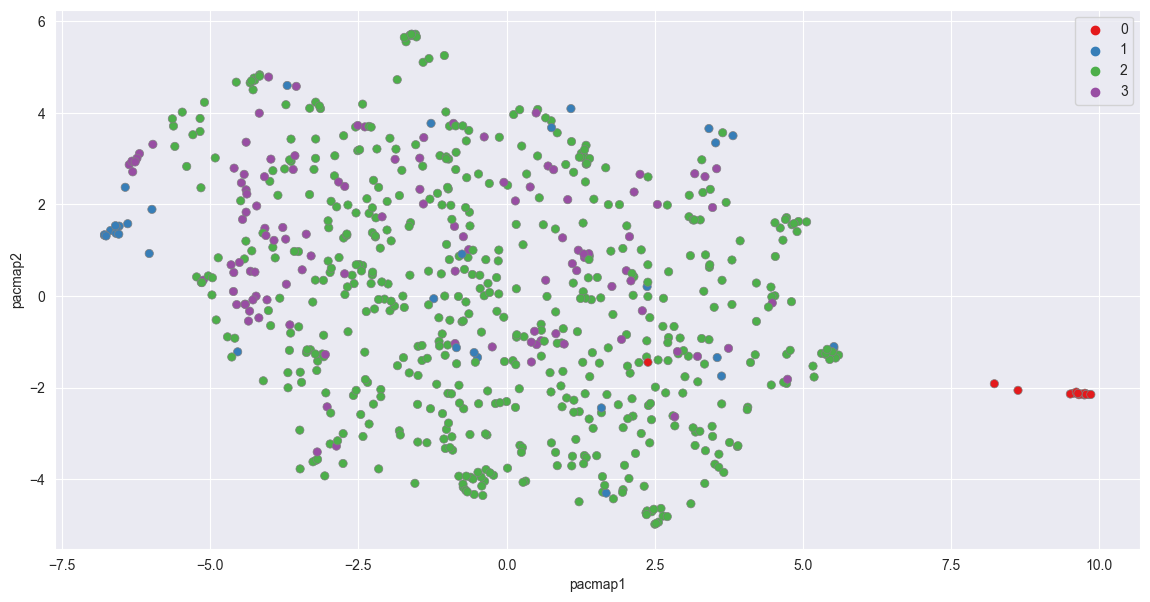

In [56]:
sns.set_style("darkgrid")
plt.figure(figsize=(14,7),dpi=100)
sns.scatterplot(x=results["pacmap1"], y=results["pacmap2"], hue=results["clusters"], palette="Set1", legend="full", edgecolor="gray");
plt.legend();

<font color="red" size="6"> Experimento 2</font>

In [57]:
tfidf_vect2 = TfidfVectorizer(tokenizer=None, 
                             lowercase=False,
                            use_idf=True,
                            ngram_range=(2,2),
                            max_features=3000)

#ajustamos vectorizador a los datos
tfidf_vect2.fit(entrada_sin_lematizar)

#implementamos matriz tf-idf
tfidf_data_bigram_sin_lematizar = tfidf_vect2.transform(entrada_sin_lematizar)

tfidf_df_bigram_sin_lematizar = pd.DataFrame(tfidf_data_bigram_sin_lematizar.toarray(), columns=tfidf_vect2.get_feature_names_out())

In [58]:
pca = PCA(n_components=300).fit(tfidf_data_bigram_sin_lematizar.toarray())
pca_data = pca.transform(tfidf_data_bigram_sin_lematizar.toarray())
np.sum(pca.explained_variance_ratio_)

0.5353547731165043

RESULTADO NO REPRODUCIBLE<br>
**Da la impresion que el mejor corte es en 4, 10 o 14.**, sigue siendo un elbow feo.

In [3]:
find_optimal_clusters(pca_data, 20)

**Con un texto tan pequeño, no es buena idea hacer bigramas, probablemente todos los bigramas tienen una frequencia de 1 (no se repiten)**

- El experimento de cluster con Bi-gramas lo considero fallido, es cosa de mirar el tamaño de los clusters, 1 solo cluster contiene casi todos los documentos.

In [60]:
clusters = KMeans(n_clusters=4, random_state=20).fit_predict(pca_data)
pd.Series(clusters).value_counts()

1    685
2     12
3      9
0      8
dtype: int64

# <font color="red"> Bonus: LDA</font>

De ahora en adelante utilizare solo uni-gramas y las frases preprocesadas sin lematizar.

In [61]:
df = df.drop(["frases_preprocesadas_tokenizadas","largo_de_documento"],axis=1)

In [62]:
df.head()

,frases_limpias,frases_preprocesadas_tokenizadas_sin_lematizar
0,Conciudadanos del Senado y de la Camara de Dip...,"[conciudadanos, senado, camara, diputados, cum..."
1,Aunque el texto constitucional vigente no pres...,"[aunque, texto, constitucional, vigente, presc..."
2,Desde hace setenta dias los chilenos vivimos n...,"[hace, setenta, dias, chilenos, vivimos, nueva..."
3,El gobierno de la nacion por autoridades libre...,"[gobierno, nacion, autoridades, libremente, el..."
4,La larga vigencia de la democracia entre nosot...,"[larga, vigencia, democracia, parecia, ser, fo..."


In [63]:
info = df["frases_preprocesadas_tokenizadas_sin_lematizar"].to_list()

In [64]:
#importamos modulo gensim para la generacion del corpus
import gensim.corpora as corpora
# creamos diccionario
id2word = corpora.Dictionary(info)

corpus = [id2word.doc2bow(text) for text in info] # creamos DTM

# Vista del corpus para el primer elemento
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]]


In [65]:
import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis
import pyLDAvis.sklearn
from gensim.models import CoherenceModel
import gensim

C:\Users\56976\anaconda3\envs\TimeSeriesDarts\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


**Busco hyperparametros que maximizen la coherencia**

In [66]:
def objective(trial, corpus, id2word, info):
    
    
    param_grid = {
        "random_state": 100,
        "workers": 11,
        "corpus": corpus,
        "id2word": id2word,
        "alpha": trial.suggest_float("alpha", 0.1, 1),
        "eta": trial.suggest_float("eta", 0.2, 1),
        "num_topics": trial.suggest_int("num_topics", 2, 10,step=1), # numero de topicos
        "chunksize": 200,
        "passes": 10
    }
    
    
    lda_model = gensim.models.LdaMulticore(**param_grid)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=info, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [67]:
#optuna.logging.set_verbosity(optuna.logging.INFO)

# study = optuna.create_study(direction="maximize", study_name="LDA",sampler=TPESampler())
# func = lambda trial: objective(trial, corpus, id2word, info)
# study.optimize(func, n_trials=50)

In [68]:
# best_params = study.best_params
# best_params

In [69]:
# lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, chunksize=200, passes=10, random_state=100,
#                                        workers=11, alpha= 0.594, num_topics=8, eta =0.968)
    
# coherence_model_lda = CoherenceModel(model=lda_model, texts=info, dictionary=id2word, coherence='c_v')

# coherence_model_lda.get_coherence()

**Latent Dirichlet Allocation (LDA)** is a probabilistic generative model for collections of discrete data, such as text documents. It is often used in natural language processing and information retrieval tasks.

In LDA, a document is represented as a mixture of topics, where each topic is a distribution over words in the vocabulary. A topic is a group of words that frequently occur together in the same context. For example, a topic in a collection of news articles might be "politics," and the words in this topic might include "government," "president," "election," and so on.

The goal of LDA is to infer the set of topics and the topic distributions for each document in a collection, given only the word frequencies in the documents. It does this by using Bayesian inference to estimate the posterior distribution over the latent variables (the topics and topic distributions) given the observed data (the word frequencies).

One way to think about LDA is as a way to cluster documents into a set of topics, where the words in each document are used to define the clusters. LDA can also be used to generate new documents by sampling from the learned topic distributions and using the words with the highest probabilities in each topic to form the new document.

Overall, LDA is a useful tool for understanding the latent structure of a collection of documents and for generating new documents that are similar in style and content to the original collection.

LDA main assumption is:

- Documents are a mixture of topics, and Topics are a mixture of tokens (or words)

The documents are known as the probability density (or distribution) of topics and the topics are the probability density (or distribution) of words.

Other Assumptions/implications of LDA for Topic Modelling:

- Documents with similar topics use similar groups of words.
- Latent topics can then be found by searching for groups of words that frequently occur together in documents across the corpus.
- Documents are probability distributions over latent topics which signifies certain document will contain more words of a specific topic.

In [70]:
# pyLDAvis.enable_notebook()
# # visualizamos topicos
# vis= pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
# pyLDAvis.save_html(vis, 'modelo.html')
# pyLDAvis.display(vis)

# <font color="red"> Analisis de Sentimiento</font>

**Cargo el lexico afinn**

In [71]:
#Cargamos csv con el lexico afinn
lexicon=pd.read_csv('lexico_afinn.en.es.csv', sep=',', encoding='latin1')
lexicon = lexicon.drop(["Word;"], axis=1)

In [72]:
lexicon.shape

(2476, 2)

Voy a enchular el lexico con el siguiente aproach, estos otros lexicos de sentimiento, los saque de Kaggle [link](https://www.kaggle.com/datasets/rtatman/sentiment-lexicons-for-81-languages), pero no vienen con puntuaciones, solo señala si la palabra es de connotacion negativa o positiva.

Al lexico preexistente le añadire las palabras de estos nuevos lexicos solo si no se encuentran ya presentes.

a las nuevas palabras positivas les dare un puntaje de 1.

a las nuevas palabras negativas les dare un puntaje de -1.

In [73]:
positivas = pd.read_csv("positive_words_es.txt")
negativas = pd.read_csv("negative_words_es.txt")

In [74]:
"abandonar" in lexicon["Palabra"].to_list()

True

In [75]:
# Funcion de enchulamiento.

for row in positivas.itertuples():
    _, palabra = row
    
    if palabra not in lexicon["Palabra"].to_list():
        
        lexicon.loc[lexicon.shape[0]] = [palabra, 1]
        
    else:
        pass
    
for row in negativas.itertuples():
    _, palabra = row
    
    if palabra not in lexicon["Palabra"].to_list():
        
        lexicon.loc[lexicon.shape[0]] = [palabra, -1]
        
    else:
        pass  

**Vemos que el lexico se extendio bastante**

In [76]:
lexicon.shape

(5744, 2)

**Defino la funcion para asignar polaridades a mis documentos**

In [77]:
#creamos funcion que identifica el puntaje para una cadena
def sentimiento(cadena):
    
    #creamos una cadena unificada con las palabras
    lexis=' '.join(lexicon.Palabra)
    
    #creamos lista con los puntajes
    punct=list(lexicon.Puntuacion)
    
    #creamos listas para almacenar la palabra y el puntaje
    palabra=[]
    puntaje=[]
    pu=[]
    
    #separamos la cadena en cada una de sus palabras
    palabras=cadena.split()
    pfinal=np.nan
    
    #iniciamos ciclo de busqueda y recuperacion de puntaje
    #print('Iniciando ciclo de busqueda')
    for p in palabras:
        try:
            #buscamos cada palabra en el lexico
            t=re.search(p,lexis).group()      
            #almacenamos la palabra en la lista de palabras
            palabra.append(t)
            #recuperamos el puntaje de la tabla
            #ojo que de la traduccion en ingles hay terminos repetidos (por ejemplo, cheerful y glad tienen la misma traduccion)
            pu=lexicon[lexicon['Palabra']==t]['Puntuacion'].mean()
            #almacenamos el puntaje en la lista correspondiente
            puntaje.append(pu)
            
        except AttributeError:
            continue
    #print('Caculando puntaje final')        
    #calculamos la media ignorando eventuales nan
    pfinal=np.nanmean(puntaje)
    
    #si el resultado es nan
    if np.isnan(pfinal)==True:
        #pasamos a ceros
        pfinal=np.nan_to_num(pfinal)
    else:
        #sino, manetenemos puntaje
        pfinal
     #retornamos resultado
    return(pfinal)     

**aplico mi funcion sentimiento**

In [78]:
#implementamos funcion de asignación de polaridades
df["frases_limpias"] = df["frases_limpias"].apply(lambda x: x.lower())
df['polaridad'] = df["frases_limpias"].apply(lambda x: sentimiento(x))

In [79]:
df.head(10)

,frases_limpias,frases_preprocesadas_tokenizadas_sin_lematizar,polaridad
0,conciudadanos del senado y de la camara de dip...,"[conciudadanos, senado, camara, diputados, cum...",-0.333333
1,aunque el texto constitucional vigente no pres...,"[aunque, texto, constitucional, vigente, presc...",0.222222
2,desde hace setenta dias los chilenos vivimos n...,"[hace, setenta, dias, chilenos, vivimos, nueva...",-1.000000
3,el gobierno de la nacion por autoridades libre...,"[gobierno, nacion, autoridades, libremente, el...",0.400000
4,la larga vigencia de la democracia entre nosot...,"[larga, vigencia, democracia, parecia, ser, fo...",3.000000
5,su restablecimiento causa alegria y esperanza ...,"[restablecimiento, causa, alegria, esperanza, ...",2.000000
6,al mismo tiempo nos impone a todos la responsa...,"[mismo, tiempo, impone, responsabilidad, conso...",-1.333333
7,esta responsabilidad senores parlamentarios re...,"[responsabilidad, senores, parlamentarios, rec...",0.875000
8,un nuevo espiritu impera en la convivencia nac...,"[nuevo, espiritu, impera, convivencia, nacional]",1.000000
9,al clima de confrontacion descalificaciones od...,"[clima, confrontacion, descalificaciones, odio...",-1.500000


**Utilizo tf-idf para preparar mi data para el modelo de regression subsiguiente**

In [80]:
tfidf_vect = TfidfVectorizer(tokenizer=None, 
                             lowercase=False,
                            use_idf=True,
                            ngram_range=(1,1),
                            max_features=1500)

#ajustamos vectorizador a los datos
tfidf_vect.fit(entrada_sin_lematizar)

#implementamos matriz tf-idf
tfidf_data_unigram_sin_lematizar= tfidf_vect.transform(entrada_sin_lematizar)

tfidf_df_unigram_sin_lematizar = pd.DataFrame(tfidf_data_unigram_sin_lematizar.toarray(),
                                             columns=tfidf_vect.get_feature_names_out())

**No es necesario normalizar variable dependiente**

In [81]:

label=df[['polaridad']].astype(float)

#variables independientes
features = tfidf_df_unigram_sin_lematizar 

**Separo en test de prueba y test de validacion**

In [82]:
#segmentacion de muestras para train-test
features_train, features_test, label_train, label_test = train_test_split( 
    features,
    label,
    test_size=0.2, 
    random_state = 11
)

In [83]:
def regression_report(y_true, y_pred):
    return {
        'mae': mean_absolute_error(y_true, y_pred),
        'rmse': mean_squared_error(y_true, y_pred, squared=False)
    }

**Realizo busqueda de mejores hyperparametros con crossvalidation incluido**

In [84]:
def objective(trial, X, y):
    params = {
            'C': trial.suggest_float('C', 0.01, 10, log=True),
            'epsilon': trial.suggest_float("epsilon", 0.001, 10),
            'gamma': trial.suggest_categorical("gamma", ['scale',"auto"]),
            'kernel': trial.suggest_categorical("kernel", ['linear'])}    
    
    cv = KFold(n_splits=3, shuffle=True, random_state=12)
    y = y.values.reshape(-1)
    cv_scores = []

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y[train_idx], y[test_idx]
        
        model = SVR(**params) 
        
        model.fit(X_train,y_train)
            
        preds =  model.predict(X_val)        
        
        cv_score = mean_squared_error(y_val , preds, squared=False)
        cv_scores.append(cv_score)
        
        z = np.mean(cv_scores)

        trial.report(z, idx)
        
        if trial.should_prune():
            raise optuna.TrialPruned()

    return np.mean(cv_scores)

In [85]:
optuna.logging.set_verbosity(optuna.logging.WARN)

study = optuna.create_study(direction='minimize', sampler=TPESampler(),
                            pruner=optuna.pruners.PercentilePruner(50, n_startup_trials=5, n_warmup_steps=2))
#study.enqueue_trial(try_this_first)
func = lambda trial: objective(trial, features_train, label_train)
study.optimize(func, n_trials=100)

In [86]:
params = study.best_params

model = SVR(**study.best_params)

model.fit(features_train, label_train.values.reshape(-1))

SVR(C=1.142993786262168, epsilon=0.050741090073246925, gamma='auto',
    kernel='linear')

In [87]:
#obtenemos predicciones
svm_predictions = model.predict(features_test)

In [88]:
svm_regression_report = regression_report(label_test, svm_predictions)
svm_regression_report

{'mae': 0.6268846277868382, 'rmse': 0.7932037183586382}

**Aqui observamos mirando los coeficientes, los tokens o palabras que tienen un mayor efecto en polaridades negativas o positivas de documentos segun el modelo**

In [89]:
coefs_score=pd.DataFrame(list(model.coef_)).T

coefs_score=coefs_score.rename(columns={coefs_score.columns[0]: 'Beta'})
var_tab=pd.DataFrame(features.columns)
var_tab=var_tab.rename(columns={var_tab.columns[0]: 'Var'})
coef_tab=pd.concat([var_tab, coefs_score], axis=1)
coef_tab=coef_tab.sort_values(by=['Beta'], ascending=False).reset_index()
coef_tab

,index,Var,Beta
0,857,mayor,2.735448
1,796,justicia,1.751806
2,731,importante,1.594005
3,1075,politicos,1.262685
4,327,crecimiento,1.193629
...,...,...,...
1495,839,mal,-1.382643
1496,1140,problemas,-1.400583
1497,1485,violencia,-1.478770
1498,482,enemigos,-1.836580


**Bonus: Clasificacion**

tratare el problema como uno de clasificacion, mapeare la variable label como 3 clases, negativo (-1),  positivo(1).

In [90]:
def polaridad_a_classificacion(polaridad):
    
    if polaridad > 0:
        return 1
    
    else:
        return -1

In [91]:
label_classificacion = label["polaridad"].apply(lambda x: polaridad_a_classificacion(x))

In [92]:
features_train, features_test, label_train, label_test = train_test_split( 
    features,
    label_classificacion,
    test_size=0.2, 
    random_state = 11
)

In [93]:
model = MultinomialNB()
model.fit(features_train, label_train)

preds = model.predict(features_test)
preds_probs = model.predict_proba(features_test)

**Al modelo no le va ni muy bien, ni muy mal en mi opinion, es sin duda mejor que el azar, pareciera irle mejor prediciendo sentimiento positivos que negativos, igual todo este experimento con el lexico hay que tomarselo con una pizca de sal, idealmente las frases deberian ser "etiquetadas" a mano por un humano, en lugar de usar el lexico afinn para calcular su polaridad.**

In [94]:
#dejo el misterio de como construi esto :).

#bin_class_report_model(preds, preds_probs, label_test, class_names=None)

In [95]:
x = pd.DataFrame(df.frases_limpias.loc[label_test.index])
x["sentimiento_segun_lexico"] = label_test
x["prediccion_del_modelo"] = preds

**Observamos unas cuantas preddiciones en el set de prueba donde nuestro modelo fue en teoria exitoso en predecir el sentimiento de la frase (segun el lexico).**

In [96]:
pd.set_option('display.max_colwidth', None)

x[x["sentimiento_segun_lexico"] == x["prediccion_del_modelo"]].tail(20)

,frases_limpias,sentimiento_segun_lexico,prediccion_del_modelo
712,el gobierno el congreso nacional los tribunales de justicia los partidos politicos las organizaciones sociales tenemos en esta etapa una responsabilidad historica estar a la altura de lo que chile tiene derecho a reclamarnos y nuestro pueblo espera de nosotros,1,1
214,en los ultimos anos chile ha experimentado un crecimiento economico y modernizaciones importantes en diversos sectores de la actividad nacional,1,1
93,ruego a los honorables parlamentarios considerar estos proyectos sin prejuicios ni suposiciones y despacharlos con urgencia,-1,-1
240,lo anterior no significa que unos y otros renuncien a sus legitimas reivindicaciones y puntos de vista ni tampoco a su autonomia independencia y funciones propias,-1,-1
243,en efecto trabajadores empresarios y gobierno concuerdan en que chile tiene hoy como nunca antes una oportunidad historica de conjugar democracia politica con desarrollo economico y con justicia social,1,1
508,para ello se creara un fondo nacional de desarrollo tecnologico que complemente el actual fondo de desarrollo productivo de a fin de fomentar la utilizacion de nuevas tecnologias en la produccion nacional e incentivar la inversion en proyectos innovadores,1,1
602,pero en la misma medida en que lo ha hecho se han ido complicando los problemas de disposicion de las aguas servidas,-1,-1
536,chile enfrentara en buena posicion diplomatica y economica los desafios de la unidad europea,1,1
453,sabemos que el ajuste trae consigo un cierto grado de desactivacion que perjudica principalmente a algunos tipos de actividad,1,1
616,se han realizado obras menores motivadas por la ley de fomento a la inversion privada en riego mecanismo valioso que este gobierno fortalecera buscando llegar tambien a los pequenos agricultores y campesinos que no han tenido oportunidad de contar masivamente con este beneficio,1,1


# <font color="red"> Word2vec</font>

In [97]:
data = pd.DataFrame(df["frases_preprocesadas_tokenizadas_sin_lematizar"])
data = data["frases_preprocesadas_tokenizadas_sin_lematizar"].to_list()

https://spacy.io/models/es

In [98]:
#!python -m spacy download es
from gensim.models.phrases import Phrases, Phraser
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [99]:
phrases = Phrases(data, min_count=3, progress_per=200)

INFO - 22:13:40: collecting all words and their counts
INFO - 22:13:40: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 22:13:40: PROGRESS: at sentence #200, processed 3099 words and 4436 word types
INFO - 22:13:40: PROGRESS: at sentence #400, processed 5991 words and 7885 word types
INFO - 22:13:40: PROGRESS: at sentence #600, processed 8791 words and 11121 word types
INFO - 22:13:40: collected 13043 token types (unigram + bigrams) from a corpus of 10595 words and 714 sentences
INFO - 22:13:40: merged Phrases<13043 vocab, min_count=3, threshold=10.0, max_vocab_size=40000000>
INFO - 22:13:40: Phrases lifecycle event {'msg': 'built Phrases<13043 vocab, min_count=3, threshold=10.0, max_vocab_size=40000000> in 0.02s', 'datetime': '2022-12-31T22:13:40.555413', 'gensim': '4.3.0', 'python': '3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}


In [100]:
gram = Phraser(phrases)

INFO - 22:13:40: exporting phrases from Phrases<13043 vocab, min_count=3, threshold=10.0, max_vocab_size=40000000>
INFO - 22:13:40: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<61 phrases, min_count=3, threshold=10.0> from Phrases<13043 vocab, min_count=3, threshold=10.0, max_vocab_size=40000000> in 0.02s', 'datetime': '2022-12-31T22:13:40.586329', 'gensim': '4.3.0', 'python': '3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}


In [101]:
sentences = gram[data]

In [102]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(min_count = 2, #ignora todas las palabras con una frequencia menor a esto.
                     window = 3, # it determines the number of words to consider to the left and right of the target word when training the model.
    #if window is set to 2, the model will consider the two words to the left and the two words to the right of the target word when training
                     vector_size = 128, #embedding size
                     sample = 6e-5, 
                     alpha = 0.005,   # Learning rate
                     min_alpha = 0.0001,  # Learning rate starts decreasing an this is the minimum rate it can achieve.
                     negative = 10,
                     workers= 11)

INFO - 22:13:40: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=128, alpha=0.005>', 'datetime': '2022-12-31T22:13:40.616249', 'gensim': '4.3.0', 'python': '3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}


In the Gensim implementation of the Word2Vec model, the **negative** parameter determines the number of negative examples to use when training the model using negative sampling. Negative sampling is a technique used to train the model more efficiently by sampling a small number of negative examples (i.e., examples that are not the target word) and using them to update the model weights, rather than using all of the context words as positive examples.

The negative parameter specifies the number of negative examples to use when training the model. For example, if negative is set to 5, the model will use 5 negative examples when training each target word. The negative examples are chosen according to a sampling distribution over the vocabulary, which is determined by the frequency of the words in the training data.

The negative parameter can be used to control the trade-off between training time and model quality. Setting negative to a higher value will use more negative examples when training, which can improve model performance but may also increase training time.

------------------------------------------------------------------------------------------------------------------------------------------------------

The **sample** parameter can be used to control the trade-off between training time and model quality.
Setting sample to a higher value will reduce the size of the training data more aggressively,
which can speed up training but may also degrade model performance.

In [103]:
w2v_model.build_vocab(sentences, progress_per=200)

INFO - 22:13:40: collecting all words and their counts
INFO - 22:13:40: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 22:13:40: PROGRESS: at sentence #200, processed 2999 words, keeping 1722 word types
INFO - 22:13:40: PROGRESS: at sentence #400, processed 5798 words, keeping 2720 word types
INFO - 22:13:40: PROGRESS: at sentence #600, processed 8518 words, keeping 3574 word types
INFO - 22:13:40: collected 4004 word types from a corpus of 10280 raw words and 714 sentences
INFO - 22:13:40: Creating a fresh vocabulary
INFO - 22:13:40: Word2Vec lifecycle event {'msg': 'effective_min_count=2 retains 1645 unique words (41.08% of original 4004, drops 2359)', 'datetime': '2022-12-31T22:13:40.650158', 'gensim': '4.3.0', 'python': '3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'prepare_vocab'}
INFO - 22:13:40: Word2Vec lifecycle event {'msg': 'effective_min_count=2 leaves 7921 word corpus (77.05% 

In [104]:
from collections import defaultdict

word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

4004

In [105]:
sorted(word_freq, key= word_freq.get, reverse=True)[:10]

['gobierno',
 'pais',
 'chile',
 'nacional',
 'desarrollo',
 'politica',
 'recursos',
 'sector',
 'mayor',
 'situacion']

In [106]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=20, report_delay=1, compute_loss=True)

INFO - 22:13:40: Word2Vec lifecycle event {'msg': 'training model with 11 workers on 1645 vocabulary and 128 features, using sg=0 hs=0 sample=6e-05 negative=10 window=3 shrink_windows=True', 'datetime': '2022-12-31T22:13:40.739918', 'gensim': '4.3.0', 'python': '3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
INFO - 22:13:40: EPOCH 0: training on 10280 raw words (3062 effective words) took 0.0s, 323614 effective words/s
INFO - 22:13:40: EPOCH 1: training on 10280 raw words (3027 effective words) took 0.0s, 444768 effective words/s
INFO - 22:13:40: EPOCH 2: training on 10280 raw words (3011 effective words) took 0.0s, 749359 effective words/s
INFO - 22:13:40: EPOCH 3: training on 10280 raw words (3099 effective words) took 0.0s, 436221 effective words/s
INFO - 22:13:40: EPOCH 4: training on 10280 raw words (3090 effective words) took 0.0s, 477655 effective words/s
INFO - 22:13:40: EPOCH 5: training on 10280 ra

(61461, 205600)

In [107]:
w2v_model.get_latest_training_loss()

468928.4375

The positive and negative parameters of the most_similar method in the Gensim Word2Vec model are used to specify which words to consider when finding the most similar words to a given word or phrase.

The positive parameter is a list of words that should be considered when ranking the similar words. The negative parameter is a list of words that should be excluded from the results.

In [108]:
# 10 Palabras mas similares positivas en relacion a las 3 palabras seleccionadas, 

# Le puedo asignar pesos en forma de tupla a las busquedas, peso positivo default = 1, peso negativo default = -1

w2v_model.wv.most_similar(positive=["acuerdos","nacional","futuro"], negative=[("pasado",-0.5)])

[('aislados', 0.27953091263771057),
 ('suposiciones', 0.2680034339427948),
 ('inferior', 0.25481387972831726),
 ('desposeidos', 0.24665260314941406),
 ('principal', 0.22879476845264435),
 ('permitan', 0.2222922295331955),
 ('servicio_nacional', 0.22121433913707733),
 ('propender', 0.22045361995697021),
 ('deterioradas', 0.21905964612960815),
 ('facil', 0.21861200034618378)]

In [109]:
# estas parecen mucho mas similares a violencia, las estoy pasando como negativo, pense que me darian el opuesto a violencia

w2v_model.wv.most_similar(negative=["violencia"])

[('conviccion', 0.24567453563213348),
 ('educacion', 0.23919248580932617),
 ('merece', 0.23268212378025055),
 ('rentables', 0.23214490711688995),
 ('vista', 0.23006319999694824),
 ('llevar', 0.224399596452713),
 ('expectativas', 0.22390633821487427),
 ('orientado', 0.2145625799894333),
 ('postergados', 0.21147020161151886),
 ('destituidos', 0.20958560705184937)]

In [110]:
# estas parecen ser lo opuesto a violencia en mi opinion y eso que lo estoy pasando como positivo

w2v_model.wv.most_similar(positive=["violencia"])

[('estatales', 0.32596322894096375),
 ('organismos', 0.27899837493896484),
 ('unidad_nacional', 0.2758759558200836),
 ('obtener', 0.2676882743835449),
 ('confrontacion', 0.2610078752040863),
 ('siglo', 0.2400483638048172),
 ('saneamiento', 0.23903638124465942),
 ('reglamentaciones', 0.23708581924438477),
 ('quinta', 0.23610465228557587),
 ('vida_nacional', 0.23606154322624207)]

In [111]:
# Aqui si me esta entregando correctamente el opuesto cuando uso el negativo, a diferencia de cuando usa la palabra violencia.

w2v_model.wv.most_similar(negative=["acuerdos","nacional","futuro"])

[('consiguiente', 0.24270173907279968),
 ('vital', 0.24097511172294617),
 ('docente', 0.23485802114009857),
 ('eliminar', 0.22785942256450653),
 ('gastos', 0.22449363768100739),
 ('inscritos', 0.22194889187812805),
 ('heridas', 0.21987757086753845),
 ('compatibles', 0.21834325790405273),
 ('manera', 0.21796834468841553),
 ('intencion', 0.21607258915901184)]

In [112]:
w2v_model.wv.most_similar(positive=["acuerdos","nacional","futuro"])

[('suposiciones', 0.26644083857536316),
 ('aislados', 0.2464437186717987),
 ('politica', 0.24607329070568085),
 ('desposeidos', 0.23679369688034058),
 ('deterioradas', 0.23562359809875488),
 ('inferior', 0.2302134931087494),
 ('real', 0.224045529961586),
 ('pues', 0.22148972749710083),
 ('defensa', 0.21799418330192566),
 ('aporte', 0.20944096148014069)]

In [113]:
# Enemigo es la que menos calza de estas palabras.

w2v_model.wv.doesnt_match(["desarrollo","economia","enemigos"])

'enemigos'

In [114]:
from sklearn.manifold import TSNE

def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    
    # aqui va el tamaño de embedding que es 128.
    arrays = np.empty((0, 128), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0) #obtengo el embedding de la palabra seleccionada
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word]) # Obtengo las 10 palasbras mas similares positivas a la palabra seleccionada
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]]) #obtengo embedding de las palabras mas similares a la seleccionada
        word_labels.append(wrd_score[0]) # guardo el nombre de las palabras mas similares
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:  # aqui viene lo mismo de arriba pero con las palabras mas distintas.
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    print(arrays.shape)
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    #reduc = PCA(n_components=21).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15, init="pca").fit_transform(arrays)
    #Y = pacmap.PaCMAP(n_components=2, random_state=0, n_neighbors=1, distance="euclidean" ).fit_transform(arrays)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('T-SNE visualizacion para {}'.format(word.title()))

(21, 128)


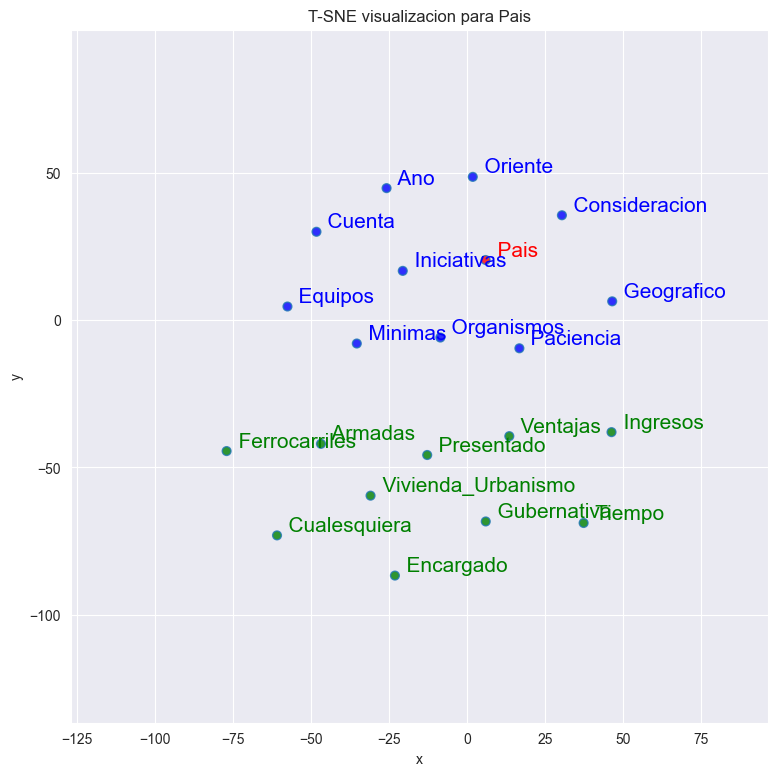

In [115]:
# palabra seleccionada acompañada de 10 terminos mas similares, vs 10 terminos mas distintos.

tsnescatterplot(w2v_model, 'pais', [i[0] for i in w2v_model.wv.most_similar(negative=["pais"])]);

### BERTOPIC

In [151]:
detok = TreebankWordDetokenizer()

entrada_sin_lematizar = df.frases_preprocesadas_tokenizadas_sin_lematizar.apply(lambda x : detok.detokenize(x))

entrada_sin_lematizar = entrada_sin_lematizar.to_list() 

In [176]:
from umap import UMAP
umap_model = UMAP(n_neighbors=15, 
                  n_components=5, 
                  min_dist=0.0, 
                  metric='cosine', 
                  random_state=100)

In [187]:
topic_model = BERTopic(language="spanish", verbose=1) #nr_topics="auto" to use hdbscan  , language="spanish"
topics, probs = topic_model.fit_transform(entrada_sin_lematizar) #diversity=True

INFO - 05:04:20: Load pretrained SentenceTransformer: paraphrase-multilingual-MiniLM-L12-v2
INFO - 05:04:21: Use pytorch device: cuda


Batches:   0%|          | 0/23 [00:00<?, ?it/s]

2023-01-01 05:04:22,362 - BERTopic - Transformed documents to Embeddings
2023-01-01 05:04:24,998 - BERTopic - Reduced dimensionality
2023-01-01 05:04:25,031 - BERTopic - Clustered reduced embeddings


topic -1 refers to all outliers and should typically be ignored.

In [188]:
topic_model.get_topic_info()#.drop(0)  # 

,Topic,Count,Name
0,-1,132,-1_gobierno_nacional_pais_politica
1,0,266,0_recursos_sector_ciento_inversion
2,1,103,1_chile_chilenos_cooperacion_economica
3,2,44,2_violencia_verdad_reconciliacion_solo
4,3,35,3_democracia_partidos_gobierno_derechos
5,4,34,4_educacion_superior_sistema_calidad
6,5,26,5_laboral_trabajo_trabajadores_legislacion
7,6,25,6_armadas_fuerzas_gobierno_defensa
8,7,17,7_pais_deber_gobierno_senores
9,8,16,8_participacion_comunidad_necesario_cultura


In [189]:
#getting topic 0

topic_model.get_topic(0)

[('recursos', 0.03131255287040925),
 ('sector', 0.030378826657126747),
 ('ciento', 0.02220519749575735),
 ('inversion', 0.021496981570210193),
 ('desarrollo', 0.021388498278208733),
 ('crecimiento', 0.01905496347887654),
 ('transporte', 0.019009160052728062),
 ('capacidad', 0.01887752348575478),
 ('servicios', 0.017944857586620518),
 ('empresas', 0.016096042135625252)]

In [190]:
warnings.filterwarnings("ignore")

topic_model.visualize_topics(width=1000,height=700)

In [181]:
topic_model.visualize_barchart()

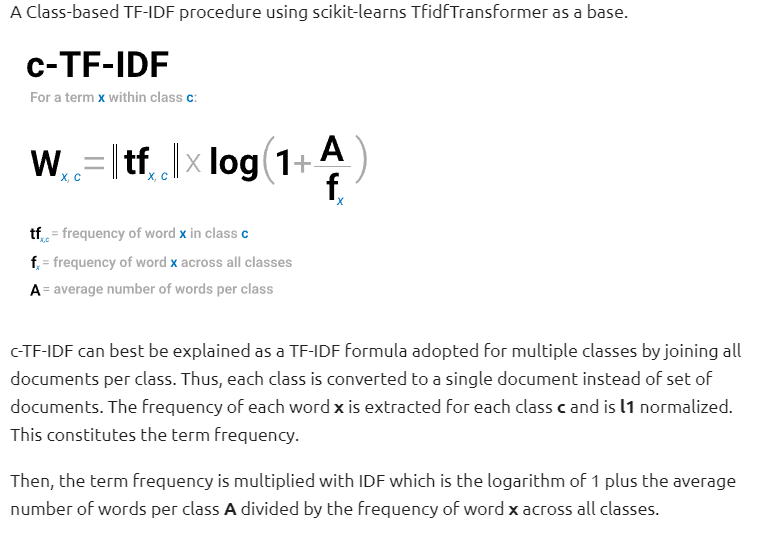

In [182]:
topic_model.c_tf_idf_

<9x3957 sparse matrix of type '<class 'numpy.float64'>'
	with 6483 stored elements in Compressed Sparse Row format>

In [183]:
topic_model.visualize_documents(docs=entrada_sin_lematizar, width=1000, hide_annotations=True)

Batches:   0%|          | 0/23 [00:00<?, ?it/s]

In [184]:
bert_topics_df = pd.concat([pd.DataFrame(df.frases_limpias.values,
                                         columns=["documentos"]),pd.DataFrame(topics, columns=["topicos"])], axis=1)

In [185]:
bert_topics_df[bert_topics_df["topicos"]==2].head(10)

,documentos,topicos
1,aunque el texto constitucional vigente no prescribe ante quien ha de rendirse esta cuenta ni la oportunidad de hacerlo pienso que lo mas adecuado es restablecer la vieja tradicion historica que expresamente consagraba la constitucion anterior de rendir esta cuenta ante el congreso pleno el organismo mas representativo de la nacion toda en la ocasion solemne en que inicia su legislatura ordinaria y en esta fecha en que chile conmemora uno de los ejemplos de patriotismo de mas alto significado moral de nuestra historia,2
2,desde hace setenta dias los chilenos vivimos nuevamente bajo un regimen democratico,2
7,esta responsabilidad senores parlamentarios recae principalmente sobre ustedes y sobre mi que hemos recibido del pueblo de chile la confianza y el honor de dirigirlo en esta etapa trascendental de su historia,2
10,contrariando al pesimismo de errados agoreros que presagiaron caos violencia y otros males los chilenos estamos demostrando que somos capaces de vivir en libertad y que no necesitamos del imperio de la fuerza ni de constantes amenazas para mantener el orden y para trabajar,2
14,sin disminuir la gravedad de esos hechos cuya erradicacion y castigo requieren no solo de la accion de los organismos policiales y judiciales del estado sino tambien de la cooperacion responsable y pedagogica de todos nadie puede seriamente negar que chile esta viviendo una etapa promisoria de reencuentro nacional,2
15,la logica de guerra que dividia a los chilenos en amigos y enemigos ha sido superada por la logica de la paz en que todos nos reconocemos como compatriotas cualesquiera que sean nuestras diferencias,2
16,la dura experiencia de tantos anos de confrontacion y sufrimiento nos ha ensenado a superar caducos prejuicios e intransigencias ideologicas a respetar explicables discrepancias a procurar comprendernos mutuamente y a admitir que la natural diversidad no es ni puede ser obstaculo insuperable a nuestra unidad esencial como chilenos,2
17,de este modo aunque en lo material poco haya cambiado el chileno comun esta viviendo en libertad una vida mas plena y mas segura sin los miedos del pasado con alegria y esperanza porque se sabe respetado y tomado en cuenta en su dignidad de persona y llamado a participar con su propio aporte en la tarea comun de construir el futuro de la patria,2
33,he dicho reiteradamente que quiero ser el presidente de todos los chilenos,2
35,para alcanzar esa meta entiendo que mi mision es promover el reencuentro de chile con sus tradiciones de tolerancia y libertad de respeto al derecho y de rechazo a las arbitrariedades y a la opresion,2


In [186]:
topic_model.visualize_heatmap()